In [62]:
import sys
sys.path.append('../')

import controller
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt

In [63]:
CAR_MODEL = "simple"
ci = controller.Car_Interface(model = CAR_MODEL)

ci.set_gear(ci.FORWARD)

In [73]:
np.random.seed(191)
#generate input output pair
#np.random(0,1)
#([final_speed, distance_travelled],output)



#(vf^2) /2*d = a

#acceleration = (inp[0]**2) / (2*inp[1])

#output = ((5*(inp[0]**2)) / inp[1])

'''
We want to make a model that can tell you how much
you should depress the accelerator in order to achieve
a target speed after travelling a target distance.

Your goal is to randomly generate an (input, output)
pair that can be used for training or evaluating your
model. The input would be in the form of the final speed
achieved and the distance travelled and the output would
be the amount the pedal was accelerated to get there.
'''
def accelerating_distance_gen(ci):
    
    #CODE HERE
    final_speed = random.uniform(0,1)
    distance_travelled = random.uniform(0,1)*100
    expected_pedal = ((5*(final_speed**2)) / distance_travelled)
    
    inp = [final_speed, distance_travelled]
    
    amt = ((5*(inp[0]**2)) / inp[1])

    return amt, inp

In [74]:
amt, (final_speed, distance_travelled) = accelerating_distance_gen(ci)
print(f"A car applied {amt * 100:.2f}% accelerator, and achieved a speed of {final_speed * 100:.2f}% after travelling {distance_travelled:.2f} distance units")

A car applied 0.50% accelerator, and achieved a speed of 30.24% after travelling 92.06 distance units


In [75]:
'''
Function should return how much distance the car
would travel if the accelerator was being pressed amt
until it acheived final_velocity
'''
def actual_accelerating_distance(final_velocity, amt):
    #OPTIONAL CODE HERE
    d = ((5*(final_velocity**2)) / amt)
    return d

def approximate_amount(inp, tol = 1e-5, min_amt = 0, max_amt = 1):
    mid_amt = (min_amt + max_amt) / 2
    if (max_amt - min_amt < 2 * tol):
        return mid_amt

    v, accelerating_distance = inp
    if (actual_accelerating_distance(v, mid_amt) < accelerating_distance):
        return approximate_amount(inp, tol, min_amt, mid_amt)
    else:
        return approximate_amount(inp, tol, mid_amt, max_amt)

In [76]:
'''
Fully Connected Module used to predict
necessary accelerator pedal depression given
target velocity and target distance from standstill.
'''
"""
class fcn(nn.Module):

    def __init__(self):
        super().__init__()

        #CODE HERE

    def forward(self, x):

       #CODE HERE
    
"""    

# Fully Connected Network Class (a custom subclass of torch's nn module)
class fcn(nn.Module):

    def __init__(self):
        super().__init__()

        # Number of hidden units in first hidden layer
        self.H_1 = 30
        # Number of hidden units in second hidden layer
        self.H_2 = 20
        
        '''
        Weights generally [input dim, output dim] so when we multiply a vector
        of size [input dim] by a matrix of size [input dim, output dim] we get
        a vector of size [output dim].  The bias will have shape [output dim]
        so we can add it to the result of the weight-vector multiplication.
        '''
        
        #Weights and Biases for computing input -> first hidden layer
        self.W_1 = nn.Parameter(torch.randn([2, self.H_1]))
        self.B_1 = nn.Parameter(torch.randn([self.H_1]))

        #Weights and Biases for computing first -> second hidden layer
        self.W_2 = nn.Parameter(torch.randn([self.H_1, self.H_2]))
        self.B_2 = nn.Parameter(torch.randn([self.H_2]))
        
        #Weights and Biases for computing second hidden layer -> output
        self.W_3 = nn.Parameter(torch.randn([self.H_2, 1]))
        self.B_3 = nn.Parameter(torch.randn([1]))

    # Forward propogation
    def forward(self, x):
        
        # x will be a vector of length 2 containing the initial velocity and desired stopping distance
        x = torch.tensor(x, dtype = torch.float32)

        # first hidden layer computation with tanh activation
        h_1 = torch.tanh(torch.matmul(x, self.W_1) + self.B_1)
    
        # second hidden layer computation with tanh activation
        h_2 = torch.tanh(torch.matmul(h_1, self.W_2) + self.B_2)
        
        #output computation with no activation.  We technically get a vector of length 1 so we squeeze to get value.
        out = torch.squeeze(torch.matmul(h_2, self.W_3) + self.B_3)

        '''
        Our output is a scaled sigmoid (output range (0, 1.15)).  This helps model learn faster since all 
        desired outputs are in the range (0.15, 1).
        '''
        return 1.15 * torch.sigmoid(out)

In [77]:
#Initialize training parameters here

USE_LAST = False
EPOCHS = 100
NUM_BATCHES = 10
# Number of data points in a single batch
BATCH_SIZE = 10

FN = "weights_" + CAR_MODEL

model = fcn()
if(USE_LAST):
    model.load_state_dict(torch.load(open(FN + ".pt", "rb")))

#Initialize optimizer here
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for e in range(EPOCHS):
    e_loss = 0
    for b in range(NUM_BATCHES):
        b_loss = 0
        for i in range(BATCH_SIZE):
            
            #get example input output and increment batch loss based on model error
            # Generate a data point
            amt, inp = accelerating_distance_gen(ci)
                
            # Find the model's predicted acceleration amount
            out = model(inp)
                
            # Compute MSE between model output and actual
            amt_t = torch.tensor(amt)
            b_loss += (out - amt_t) ** 2

        b_loss /= BATCH_SIZE

        optimizer.zero_grad()
        b_loss.backward()
        optimizer.step()

        b_loss = b_loss.detach().numpy()
        print(f"B {b} L {b_loss:.4f}", end = "\r")
        e_loss += b_loss

    e_loss /= NUM_BATCHES
    print(f"EPOCH {e + 1} {e_loss:.4f}")

    torch.save(model.state_dict(), open(FN + ".pt", "wb"))

EPOCH 1 27.5630
EPOCH 2 0.0116
EPOCH 3 0.0224
EPOCH 4 0.0404
EPOCH 5 0.0206
EPOCH 6 0.9596
EPOCH 7 0.1870
EPOCH 8 0.2663
EPOCH 9 0.0200
EPOCH 10 22.0855
EPOCH 11 0.1992
EPOCH 12 0.0216
EPOCH 13 0.4755
EPOCH 14 0.0092
EPOCH 15 0.0181
EPOCH 16 1.7288
EPOCH 17 0.7656
EPOCH 18 0.0128
EPOCH 19 0.1681
EPOCH 20 0.0089
EPOCH 21 0.1512
EPOCH 22 0.0097
EPOCH 23 10.1512
EPOCH 24 0.1330
EPOCH 25 0.3296
EPOCH 26 0.0187
EPOCH 27 0.0567
EPOCH 28 0.0152
EPOCH 29 0.4336
EPOCH 30 0.0311
EPOCH 31 28.1813
EPOCH 32 2.5751
EPOCH 33 0.0059
EPOCH 34 0.0024
EPOCH 35 0.0080
EPOCH 36 0.1848
EPOCH 37 0.0121
EPOCH 38 0.0030
EPOCH 39 0.0358
EPOCH 40 0.1935
EPOCH 41 0.0104
EPOCH 42 0.0010
EPOCH 43 0.0059
EPOCH 44 0.1502
EPOCH 45 0.3950
EPOCH 46 0.5382
EPOCH 47 0.0911
EPOCH 48 7.1089
EPOCH 49 2.4961
EPOCH 50 0.4750
EPOCH 51 0.0877
EPOCH 52 0.0056
EPOCH 53 0.0263
EPOCH 54 1.2429
EPOCH 55 0.0094
EPOCH 56 0.2062
EPOCH 57 0.5150
EPOCH 58 0.0203
EPOCH 59 4.7090
EPOCH 60 0.0024
EPOCH 61 0.0094
EPOCH 62 0.0130
EPOCH 63 0.34

WITHIN 0.1 291/300 times
AVERAGE ERROR 0.026983693613209448


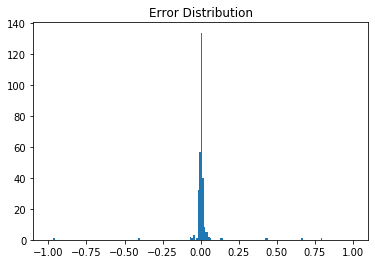

In [79]:
TEST = 300
correct = 0
tol = 0.1
errors = []
for i in range(TEST):
    print(f"TESTING {i + 1}/{TEST}", end = "\r")
    amt, inp = accelerating_distance_gen(ci)

    #run this to get FCN output
    out = model(inp).detach().numpy()
    
    #run this to use analytical output
    #out = approximate_amount(inp)

    if (abs(out - amt) < tol):
        correct += 1
    errors.append(out - amt)
print(f"WITHIN {tol} {correct}/{TEST} times")
print(f"AVERAGE ERROR {np.mean(np.abs(errors))}")

plt.title("Error Distribution")
plt.hist(errors, bins = 200, range = (-1, 1))
plt.show()